In [122]:
# 전제 : 시계열 데이터 처리
import pandas as pd
df = pd.read_csv("stock.csv")
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Volume    0
Close     0
dtype: int64

In [123]:
df.drop(["Date","Volume"], axis=1, inplace=True)

In [124]:
df

,Open,High,Low,Close
0,120,123,118,123
1,124,126,122,123
2,121,122,118,118
3,120,120,116,117
4,117,117,115,116
...,...,...,...,...
962,284,287,282,286
963,284,286,279,284
964,283,288,281,286
965,304,309,288,293


In [125]:
# stock : 
# 닫을 때 종가가 target이다 
# 주식을 며칠동안 볼건지 구간을 정해야 한다
# 한달이면 30일 
# 30일치 데이터를 가지고 내일 종가를 예측하겠다
# Open High Low 만 feature다 

In [126]:
# 딥러닝 RNN 으로 시계열 데이터 처리
# dataset, DataLoader import 하기
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# stockDataset 데이터셋 클래스 생성
# feature : Open, High, Low
# target : Close

class StockDS(Dataset):  # 클래스 선언
    def __init__(self, filename):
        self.csvDF = pd.read_csv(filename)            # 데이터 읽기

        # 입력 데이터 정규화
        self.data = self.csvDF.iloc[:, 1:4].values                        # 종가 제외한 데이터
        self.data = self.data / np.max(self.data)                       # 0과 1 사이로 정규화

        # 종가 데이터 정규화
        self.label = self.csvDF["Close"].values         
        self.label = self.label / np.max(self.label)
        
    def __len__(self):
        return len(self.data) - 30                                  # 사용 가능한 배치 개수

    def __getitem__(self, i):
        data = self.data[i:i+30]                                        # 입력 데이터 30일치 읽기
        label = self.label[i+30]                                        # 다음 날 종가 데이터 

        return data, label


In [127]:
import torch.nn as nn


class RNN(nn.Module):
   def __init__(self):
       super(RNN, self).__init__()

       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)  # RNN층의 정의

       # 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)

       self.relu = nn.ReLU() # 활성화 함수 정의
        
   def forward(self, x, h0):
       x, hn = self.rnn(x, h0)  # RNN층의 출력

       # MLP층의 입력으로 사용될 수 있도록 모양 변경
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
      
       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

In [128]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)                         # 모델의 정의
dataset = StockDS("./stock.csv")                         # 데이터셋의 정의
loader = DataLoader(dataset, batch_size=32)         # 배치 크기 32로 설정
optim = Adam(params=model.parameters(), lr=0.0001)          # 최적화 설정

In [129]:
import numpy as np
for epoch in range(50):

    for i, (x, y) in enumerate(loader):
        optim.zero_grad()
        
        h0 = torch.zeros(5, x.shape[0], 8).to(device)
        pred = model(x.type(torch.FloatTensor).to(device), h0)
        loss = nn.MSELoss()(pred, y.type(torch.FloatTensor).to(device))
            
        loss.backward()
        optim.step()

    print(epoch, loss.item())


0 0.10769069194793701
1 0.02181369438767433
2 0.012449126690626144
3 0.012483852915465832
4 0.012781981378793716
5 0.012768477201461792
6 0.012700791470706463
7 0.01264248974621296
8 0.012590251863002777
9 0.01253923587501049
10 0.012487431056797504
11 0.012433560565114021
12 0.012376337312161922
13 0.012314332649111748
14 0.012246121652424335
15 0.012170000933110714
16 0.012083988636732101
17 0.011985846795141697
18 0.01187281683087349
19 0.011741459369659424
20 0.011587534099817276
21 0.01140531525015831
22 0.011187391355633736
23 0.010923713445663452
24 0.010592729784548283
25 0.010199401527643204
26 0.009916509501636028
27 0.008401157334446907
28 0.007511220872402191
29 0.0064053307287395
30 0.004847228992730379
31 0.003012371249496937
32 0.0008468953892588615
33 0.0004985987907275558
34 0.0018279541982337832
35 0.0038502344395965338
36 0.0033625937066972256
37 0.0034587366972118616
38 0.0033160201273858547
39 0.003333688946440816
40 0.003319314680993557
41 0.0032951529137790203
42

In [130]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())                                     # 예측값 리스트에 추가
       loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))     # 손실계산
       total_loss += loss/len(loader)                                   # 손실의 평균치 계산

total_loss.item()

0.002549397526308894

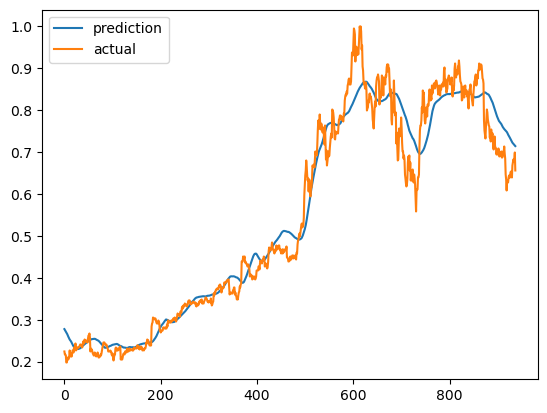

In [131]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()